In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
 
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
!pip install utils

In [ ]:
!pip install tensorpack

     |████████████████████████████████| 296 kB 9.2 MB/s 


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dropout
import torch
import torch.nn as nn
import math
from typing import Iterator, List, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
### Import necessary dependencies and libraries
import tensorflow as tf
from tensorpack.models.common import layer_register
from tensorpack.utils.argtools import shape2d, shape4d, get_data_format
from tensorpack.models import BatchNorm, BNReLU, Conv2D
import math
import utils

In [ ]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorpack.models.common import layer_register, VariableHolder
from tensorpack.tfutils.common import get_tf_version_tuple
#from tensorflow.contrib.framework.python.ops import add_arg_scope
from tensorpack.tfutils.tower import get_current_tower_context
from tensorpack.utils.argtools import shape2d, shape4d, get_data_format
from tensorpack.models.tflayer import rename_get_variable, convert_to_tflayer_args
from tensorpack.models import BatchNorm, BNReLU, Conv2D
import numpy as np
import math
import utils
__all__ = ['GhostModule', 'SELayer', 'MyConv2D', 'BNNoReLU']

In [ ]:
from tensorflow.keras.initializers import VarianceScaling
#kernel_initializer = tf.contrib.layers.variance_scaling_initializer(2.0)
kernel_initializer = tf.keras.initializers.VarianceScaling(2.0) #https://www.tensorflow.org/api_docs/python/tf/keras/initializers/VarianceScaling

In [ ]:
#inputs= layers.Input(shape=(224,224,3))
IMAGE_SIZE = [224, 224]
model = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
layer1 = Dropout(0.8)
#model.trainable = False
print(model.layers[-1].name)
layer2 = Dropout(0.9)

16711680/16705208 [==============================] - 0s 0us/step
top_activation


In [ ]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
from math import ceil
#https://github.com/CarloLepelaars/ghostnet_tf2/blob/master/ghost_bottleneck/components/ghostmodule.py
from tensorflow.keras.layers import Conv2D, Concatenate, DepthwiseConv2D, Lambda, Layer, Activation

class GhostModule(Layer):
    """
    The main Ghost module
    """
    def __init__(self, out, ratio, convkernel, dwkernel):
        super(GhostModule, self).__init__()
        self.ratio = ratio
        self.out = out
        self.conv_out_channel = ceil(self.out * 1.0 / ratio)
        self.conv = Conv2D(int(self.conv_out_channel), (convkernel, convkernel), use_bias=False,
                           strides=(1, 1), padding='same', activation=None)
        self.depthconv = DepthwiseConv2D(dwkernel, 1, padding='same', use_bias=False,
                                         depth_multiplier=ratio-1, activation=None)
        self.slice = Lambda(self._return_slices, arguments={'channel': int(self.out - self.conv_out_channel)})
        self.concat = Concatenate()

    @staticmethod
    def _return_slices(x, channel):
        return x[:, :, :, :channel]

    def call(self, inputs):
        x = self.conv(inputs)
        if self.ratio == 1:
            return x
        dw = self.depthconv(x)
        dw = self.slice(dw)
        output = self.concat([x, dw])
        return output

In [ ]:
GhostModule(1280, 2, 1, 3) #CHECK
#GhostModule(out, ratio, 1, 3)

In [ ]:
new_model = Sequential()
new_model.add(model)
new_model.add(layer1)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
new_model.add(GhostModule(1280, 2, 1, 3))
new_model.add(layer2)

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
ghost_module_1 (GhostModule) (None, 7, 7, 1280)        824960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 1280)        0         
Total params: 4,874,531
Trainable params: 4,832,508
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
x = Flatten()(new_model.layers[-4].output)
prediction = Dense(3, activation='softmax')(x)

# create a model object
model_finall = Model(inputs=model.input, outputs=prediction)

In [ ]:
model_finall.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use



model_finall.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
##FOR DRIVE IMPORT
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import random
import tensorflow as tf
import numpy as np
np.random.seed(456)
import shutil
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

os.mkdir("/content/coffee/")

In [ ]:
import zipfile
import random
import tensorflow as tf
import numpy as np
np.random.seed(456)
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
to_create = [
    "/content/coffee/split/",         
    "/content/coffee/split/train/",
    "/content/coffee/split/val/",   
    "/content/coffee/split/test/",        
        
    #creating different classes in test
    "/content/coffee/split/test/health/",
    "/content/coffee/split/test/miner/",
    "/content/coffee/split/test/rust/",
    
    #creating different classes in validation
    "/content/coffee/split/val/health/",
    "/content/coffee/split/val/miner/",
    "/content/coffee/split/val/rust/",
    
    #creating different classes in train,
    "/content/coffee/split/train/health/",
    "/content/coffee/split/train/miner/",
    "/content/coffee/split/train/rust/"

]   

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

/content/coffee/split/ created
/content/coffee/split/train/ created
/content/coffee/split/val/ created
/content/coffee/split/test/ created
/content/coffee/split/test/health/ created
/content/coffee/split/test/miner/ created
/content/coffee/split/test/rust/ created
/content/coffee/split/val/health/ created
/content/coffee/split/val/miner/ created
/content/coffee/split/val/rust/ created
/content/coffee/split/train/health/ created
/content/coffee/split/train/miner/ created
/content/coffee/split/train/rust/ created


In [ ]:
HEALTH_TEST = "/content/coffee/split/test/health/"
MINER_TEST =  "/content/coffee/split/test/miner/"
RUST_TEST = "/content/coffee/split/test/rust/"


HEALTH_VAL =  "/content/coffee/split/val/health/"
MINER_VAL =  "/content/coffee/split/val/miner/"
RUST_VAL = "/content/coffee/split/val/rust/"


HEALTH_TRAIN = "/content/coffee/split/train/health/"
MINER_TRAIN =  "/content/coffee/split/train/miner/"
RUST_TRAIN = "/content/coffee/split/train/rust/"


In [ ]:
from glob import glob
for element in glob("/content/drive/MyDrive/CCPS Research/symptom/train/1_health/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/health/")
for element in glob("/content/drive/MyDrive/CCPS Research/symptom/train/2_miner/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/miner/")
for element in glob("/content/drive/MyDrive/CCPS Research/symptom/train/3_rust/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/rust/")

for element in glob("/content/drive/MyDrive/CCPS Research/symptom/val/1_health/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/health/")
for element in glob("/content/drive/MyDrive/CCPS Research/symptom/val/2_miner/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/miner/")
for element in glob("/content/drive/MyDrive/CCPS Research/symptom/val/3_rust/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/rust/")

for element in glob("/content/drive/MyDrive/CCPS Research/symptom/test/1_health/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/health/")
for element in glob("/content/drive/MyDrive/CCPS Research/symptom/test/2_miner/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/miner/")
for element in glob("/content/drive/MyDrive/CCPS Research/symptom/test/3_rust/*.jpg"):
      shutil.copy(element, "/content/coffee/split/train/rust/")


In [ ]:
sum_all = len(os.listdir("/content/coffee/split/train/health/"))+len(os.listdir("/content/coffee/split/train/miner/"))+len(os.listdir("/content/coffee/split/train/rust/"))
print(f"Images in All = {sum_all}")

Images in All = 1421


In [ ]:
#AUGGGGG

In [ ]:
#WITH DATA GENERATION
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

def aug1(dir_name):
  DIR=dir_name
  #val_datagen_imgAdded  = ImageDataGenerator(rescale = 1./255)
  datagen = ImageDataGenerator( 
          rotation_range = 50, 
          shear_range = 0.4,
          vertical_flip = True,
          horizontal_flip = True, 
          brightness_range = (0.5, 1.5)) 

  for i in os.listdir(dir_name):
    img = load_img(dir_name+i)   # load the image
    array = img_to_array(img) # convert to numpy array
    array = array.reshape((1, ) + array.shape) 
    j = 0
    for batch in datagen.flow(array, batch_size = 1, 
                              save_to_dir =dir_name,  
                              save_format ='jpeg'): 
        j += 2
        if j > 0: 
            break
  print(len(os.listdir(dir_name)))

def aug2(dir_name):
  DIR=dir_name
  #val_datagen_imgAdded  = ImageDataGenerator(rescale = 1./255)
  datagen = ImageDataGenerator( 
          rotation_range = 50, 
          shear_range = 0.4,
          vertical_flip = True,
          horizontal_flip = True, 
          brightness_range = (0.5, 1.5)) 

  for i in os.listdir(dir_name):
    img = load_img(dir_name+i)   # load the image
    array = img_to_array(img) # convert to numpy array
    array = array.reshape((1, ) + array.shape) 
    j = 0
    for batch in datagen.flow(array, batch_size = 1, 
                              save_to_dir =dir_name,  
                              save_format ='jpeg'): 
        j += 3
        if j > 0: 
            break
  print(len(os.listdir(dir_name)))

def aug3(dir_name):
  DIR=dir_name
  #val_datagen_imgAdded  = ImageDataGenerator(rescale = 1./255)
  datagen = ImageDataGenerator( 
          rotation_range = 50, 
          shear_range = 0.4,
          vertical_flip = True,
          horizontal_flip = True, 
          brightness_range = (0.5, 1.5)) 

  for i in os.listdir(dir_name):
    img = load_img(dir_name+i)   # load the image
    array = img_to_array(img) # convert to numpy array
    array = array.reshape((1, ) + array.shape) 
    j = 0
    for batch in datagen.flow(array, batch_size = 1, 
                              save_to_dir =dir_name,  
                              save_format ='jpeg'): 
        j += 5
        if j > 0: 
            break
  print(len(os.listdir(dir_name)))

In [ ]:
aug3(MINER_TRAIN)     
aug3(RUST_TRAIN)     
aug3(HEALTH_TRAIN)     

aug2(MINER_TRAIN)     
aug2(RUST_TRAIN)     
aug2(HEALTH_TRAIN)     

1058
1225
520
2022
2303
1017


In [ ]:
aug1(MINER_TRAIN)     
aug1(RUST_TRAIN)     
aug1(HEALTH_TRAIN) 

3568
4001
1915


In [ ]:
print("")
sum_all = len(os.listdir("/content/coffee/split/train/health/"))+len(os.listdir("/content/coffee/split/train/miner/"))+len(os.listdir("/content/coffee/split/train/rust/"))
print(f"Images in All = {sum_all}")


Images in All = 7682


In [ ]:
#creating validation set
#images enhancing and resizing (takes a while ~10min)

#HEALTH
all_pathsHEALTH = []
from glob import glob
N=0
for element in glob("/content/coffee/split/train/health/*"): 
  all_pathsHEALTH.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items = random.sample(all_pathsHEALTH, num_to_select)
for element in list_of_random_items:
  p = element.split("/") 
  os.replace(element, "/content/coffee/split/val/health/"+p[-1])



In [ ]:
all_pathsHEALTH1 = []
from glob import glob
N=0
for element in glob("/content/coffee/split/train/health/*"): 
  all_pathsHEALTH1.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))    

list_of_random_items1 = random.sample(all_pathsHEALTH1, num_to_select)
for element in list_of_random_items1:
  p = element.split("/") 
  shutil.move(element, "/content/coffee/split/test/health/"+p[-1])




In [ ]:
#MINER
all_pathsMINER = []
from glob import glob
N=0
for element in glob("/content/coffee/split/train/miner/*"): 
  all_pathsMINER.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items00 = random.sample(all_pathsMINER, num_to_select)
for element in list_of_random_items00:
  p = element.split("/") 
  os.replace(element, "/content/coffee/split/val/miner/"+p[-1])



In [ ]:
#MINER
all_pathsMINER1 = []
from glob import glob
N=0
for element in glob("/content/coffee/split/train/miner/*"): 
  all_pathsMINER1.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items00 = random.sample(all_pathsMINER1, num_to_select)
for element in list_of_random_items00:
  p = element.split("/") 
  os.replace(element, "/content/coffee/split/test/miner/"+p[-1])



In [ ]:
#RUST
all_pathsRUST= []
from glob import glob
N=0
for element in glob("/content/coffee/split/train/rust/*"): 
  all_pathsRUST.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items00 = random.sample(all_pathsRUST, num_to_select)
for element in list_of_random_items00:
  p = element.split("/") 
  os.replace(element, "/content/coffee/split/val/rust/"+p[-1])



In [ ]:
#RUST
all_pathsRUST1= []
from glob import glob
N=0
for element in glob("/content/coffee/split/train/rust/*"): 
  all_pathsRUST1.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items00 = random.sample(all_pathsRUST1, num_to_select)
for element in list_of_random_items00:
  p = element.split("/") 
  os.replace(element, "/content/coffee/split/test/rust/"+p[-1])



In [ ]:
sum_train = len(os.listdir("/content/coffee/split/train/health/"))+len(os.listdir("/content/coffee/split/train/miner/"))+len(os.listdir("/content/coffee/split/train/rust/"))
sum_val = len(os.listdir("/content/coffee/split/val/health/"))+len(os.listdir("/content/coffee/split/val/miner/"))+len(os.listdir("/content/coffee/split/val/rust/"))
sum_test = len(os.listdir("/content/coffee/split/test/health/"))+len(os.listdir("/content/coffee/split/test/miner/"))+len(os.listdir("/content/coffee/split/test/rust/"))
print(f"Images in Train = {sum_train}")
print(f"Images in Validation = {sum_val}")
print(f"Images in Test = {sum_test}")

Images in Train = 7682
Images in Validation = 949
Images in Test = 853


In [ ]:
import zipfile
import random
import tensorflow as tf
import numpy as np
np.random.seed(456)
import shutil
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
train_path ='/content/coffee/split/train/'
train_datagen = ImageDataGenerator(rescale= 1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    target_size=(224, 224)
)


val_path = '/content/coffee/split/val/'
val_datagen = ImageDataGenerator(rescale= 1./255)
val_generator = val_datagen.flow_from_directory(
    val_path,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    target_size=(224, 224)
)


test_path = '/content/coffee/split/test/'
test_datagen = ImageDataGenerator(rescale= 1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    target_size=(224, 224)
)

Found 7682 images belonging to 3 classes.
Found 949 images belonging to 3 classes.
Found 853 images belonging to 3 classes.


In [ ]:
BATCH_SIZE=64

TRAINING_SIZE = 7682

VALIDATION_SIZE = 948
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)
print(steps_per_epoch)
print(val_steps)

121
15


In [ ]:
newestmodel = tensorflow.keras.models.load_model('81percentoerallcc.h5')
newestmodel.summary()

KeyError: ignored

In [ ]:
#Fit the model - train and val data used here
import tensorflow.keras.callbacks
earlystopping = tensorflow.keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
history = model_finall.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    batch_size=64,
    #steps_per_epoch=116,
    #validation_steps=56,
    steps_per_epoch=121,
    validation_steps=15,
    callbacks =[earlystopping])

Epoch 1/30
121/121 [==============================] - 81s 612ms/step - loss: 1.5702 - accuracy: 0.4130 - val_loss: 1.1059 - val_accuracy: 0.4510
Epoch 2/30
121/121 [==============================] - 73s 600ms/step - loss: 1.5823 - accuracy: 0.4313 - val_loss: 1.2126 - val_accuracy: 0.5016
Epoch 3/30
121/121 [==============================] - 72s 596ms/step - loss: 1.9407 - accuracy: 0.3830 - val_loss: 1.1213 - val_accuracy: 0.4889
Epoch 4/30
121/121 [==============================] - 72s 598ms/step - loss: 1.3084 - accuracy: 0.4227 - val_loss: 1.3940 - val_accuracy: 0.4341
Epoch 5/30
121/121 [==============================] - 72s 598ms/step - loss: 1.5370 - accuracy: 0.5502 - val_loss: 2.0189 - val_accuracy: 0.3541
Epoch 6/30
121/121 [==============================] - 72s 598ms/step - loss: 1.3041 - accuracy: 0.4836 - val_loss: 1.5503 - val_accuracy: 0.3235


In [ ]:
fhhjh=90
yuyuy=90
ghgh=fhhjh+yuyuy

In [ ]:
#model_finall.save('model_finall.h5') 
tf.keras.models.save_model(
    model_finall,
    'model_finall_Shuffle1.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

#my_model = get_model()


In [ ]:
from sklearn import metrics
Y_pred = model_finall.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_generator.classes, y_pred)
#metrics.plot_confusion_matrix(cm, labels=['cerco', 'health', 'miner', 'phoma', 'rust'])

Confusion Matrix


In [ ]:
print(cm)

[[  0   0 172]
 [  0   0 321]
 [  0   0 360]]


In [ ]:
import pandas as pd 
df = pd.DataFrame((cm))
df.to_csv()
df

,0,1,2
0,0,0,172
1,0,0,321
2,0,0,360


In [ ]:
train_path = '/content/coffee/split/train/'
val_path = '/content/coffee/split/val/'
test_path = '/content/coffee/split/test/'
print(os.listdir(train_path))
print(os.listdir(val_path))
print(os.listdir(test_path))

['rust', 'miner', 'health']
['rust', 'miner', 'health']
['rust', 'miner', 'health']


In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix


print('Classification Report')
target_names = ['rust', 'miner', 'health']



print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        rust       0.00      0.00      0.00       172
       miner       0.00      0.00      0.00       321
      health       0.42      1.00      0.59       360

    accuracy                           0.42       853
   macro avg       0.14      0.33      0.20       853
weighted avg       0.18      0.42      0.25       853



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


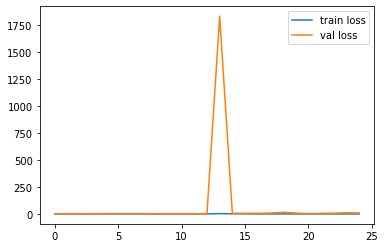

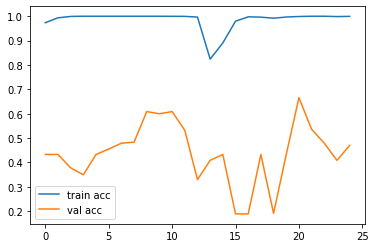

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot the training and vlidation loss
import matplotlib.pyplot as plt

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the trainng and validarion accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example